Adding Libraries

In [17]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns


Getting the Data frame ready:

In [3]:
drivers_2019 = pd.read_csv("Data/2019_drivers.csv")
drivers_2019["Year"] = 2019
drivers_2020 = pd.read_csv("Data/2020_drivers.csv")
drivers_2020["Year"] = 2020
drivers_2021 = pd.read_csv("Data/2021_drivers.csv")
drivers_2021["Year"] = 2021
drivers_2022 = pd.read_csv("Data/2022_drivers.csv")
drivers_2022["Year"] = 2022
drivers_2023 = pd.read_csv("Data/2023_drivers.csv")
drivers_2023["Year"] = 2023
drivers_2024 = pd.read_csv("Data/2024_drivers.csv")
drivers_2024["Year"] = 2024

all_drivers = pd.concat([drivers_2019, drivers_2020, drivers_2021, drivers_2022, drivers_2023, drivers_2024], axis = 0)

all_drivers
all_drivers.drop(columns=["Driver", "Highest Race Finish",  "Date of Birth", "Place of Birth", "Abbreviation"],inplace = True)
all_drivers


all_drivers["Number"] = all_drivers["Number"].fillna(all_drivers["No"])
all_drivers
all_drivers.drop(columns=["No"],inplace = True)


all_drivers["Podium Percentage"] = all_drivers["Podiums"] / all_drivers["Grands Prix Entered"]
all_drivers.head(n = 60)

all_drivers["Has WC"] = np.where(all_drivers["World Championships"] > 0, 1, 0)
all_drivers.head(n = 60)

,Number,Team,Country,Podiums,Points,Grands Prix Entered,World Championships,Highest Grid Position,Year,Podium Percentage,Has WC
0,44.0,Mercedes,United Kingdom,151,3431.0,250,6,1,2019,0.604000,1
1,77.0,Mercedes,Finland,45,1289.0,140,0,1,2019,0.321429,0
2,33.0,Red Bull Racing,Netherlands,31,948.0,102,0,1,2019,0.303922,0
3,16.0,Ferrari,Monaco,10,303.0,42,0,1,2019,0.238095,0
4,5.0,Ferrari,Germany,120,2985.0,241,4,1,2019,0.497925,1
5,55.0,McLaren,Spain,1,267.0,102,0,5,2019,0.009804,0
6,10.0,Toro Rosso,France,1,124.0,47,0,4,2019,0.021277,0
7,23.0,Red Bull Racing,Thailand,0,92.0,21,0,5,2019,0.000000,0
8,3.0,Renault,Australia,29,1040.0,171,0,1,2019,0.169591,0
9,11.0,Racing Point,Mexico,8,581.0,178,0,4,2019,0.044944,0


In [61]:
raceRes19 = pd.read_csv("Data/2019_raceResults.csv")
raceRes19["Year"] = 2019
raceRes20 = pd.read_csv("Data/2020_raceResults.csv")
raceRes20["Year"] = 2020
raceRes21 = pd.read_csv("Data/2021_raceResults.csv")
raceRes21["Year"] = 2021
raceRes22 = pd.read_csv("Data/2022_raceResults.csv")
raceRes22["Year"] = 2022
raceRes23 = pd.read_csv("Data/2023_raceResults.csv")
raceRes23["Year"] = 2023
raceRes24 = pd.read_csv("Data/2024_raceResults.csv")
raceRes24["Year"] = 2024

#finding all of the unique races in 2021
unique_races_21 = raceRes21["Track"].unique()

#setting the fastest lap of those who did not complete a lap 100 minutes to make sure they do not count 
raceRes21["Fastest Lap"] = raceRes21["Fastest Lap"].fillna("100:0.0")
#creating a new variable called "Set Fastest Lap" and setting it by default to "No"
raceRes21["Set Fastest Lap"] = "No"

#Making a functrion that will take the string time that a driver set for their fastest lap and returning it in milliseconds 
def time_to_sec(time):
    # Split into minutes and "seconds.milliseconds"
    minutes, sec_millis = time.split(":")  
    # Split seconds and milliseconds
    seconds, milliseconds = sec_millis.split(".")  
        
    # Convert all parts to integers
    total_ms = (int(minutes) * 60 + int(seconds)) * 1000 + int(milliseconds)

    #returning the total miliseconds 
    return total_ms

#for each track in the 2021 season we find the minimum time, aka the fastest lap and we check it with all of the lap times and set "Set Fastest Lap" to "Yes" or "No"
for i in range(0,len(unique_races_21)):
    track_subset = raceRes21[raceRes21["Track"] == unique_races_21[i]]
    #finding minimum value 
    fastest_time = min(track_subset['Fastest Lap'])

    #setting Yes or No to each track for "Set fastest Lap"
    raceRes21.loc[raceRes21["Track"] == unique_races_21[i], "Set Fastest Lap"] = raceRes21.loc[raceRes21["Track"] == unique_races_21[i], "Fastest Lap"].apply(lambda x: "Yes" if x == fastest_time else "No")


#repeating the process as we did for 2021, but for the 2022 season
raceRes22["Fastest Lap"] = raceRes22["Fastest Lap"].fillna("100:0.0")
raceRes22["Set Fastest Lap"] = "No"

#finding all of the unique races in 2021
unique_races_22 = raceRes22["Track"].unique()

#for each track in the 2021 season we find the minimum time, aka the fastest lap and we check it with all of the lap times and set "Set Fastest Lap" to "Yes" or "No"
for i in range(0,len(unique_races_22)):
    track_subset = raceRes21[raceRes22["Track"] == unique_races_22[i]]
    fastest_time = min(track_subset['Fastest Lap'])

    #setting Yes or No to each track for "Set fastest Lap"
    raceRes22.loc[raceRes22["Track"] == unique_races_22[i], "Set Fastest Lap"] = raceRes22.loc[raceRes22["Track"] == unique_races_22[i], "Fastest Lap"].apply(lambda x: "Yes" if x == fastest_time else "No")


#Setting the fastest lap column to equal the set fastest lap column, as we won't use it in the future
raceRes21["Fastest Lap"] = raceRes21["Set Fastest Lap"]
raceRes22["Fastest Lap"] = raceRes22["Set Fastest Lap"]


#Concatenating all of the different datasets we have for our races
all_races = pd.concat([raceRes19, raceRes20, raceRes21, raceRes22, raceRes23, raceRes24], axis = 0)


#need to merge total time/gap with time/req & need to merge fastest lap with set fastest lap
all_races["Time/Retired"] = all_races["Time/Retired"].fillna(all_races["Total Time/Gap/Retirement"])
all_races["Fastest Lap"] = all_races["Fastest Lap"].fillna(all_races["Set Fastest Lap"])

all_races.drop(columns = ["Driver", "Laps", "Total Time/Gap/Retirement", "Set Fastest Lap", "+1 Pt", "Fastest Lap Time"], inplace = True)

all_races = all_races[(all_races["Position"] != "DQ") & (all_races["Position"] != "NC")]
all_races = all_races.dropna()

all_races["Position"] = all_races["Position"].astype(int)
all_races["Starting Grid"] = all_races["Starting Grid"].astype(int)

all_races["Net Position"] = all_races["Starting Grid"] - all_races["Position"]

all_races



,Track,Position,No,Team,Starting Grid,Points,Fastest Lap,Year,Time/Retired,Net Position
0,Australia,1,77,Mercedes,2,26.0,Yes,2019,1:25:27.325,1
1,Australia,2,44,Mercedes,1,18.0,No,2019,+20.886,-1
2,Australia,3,33,Red Bull Racing Honda,4,15.0,No,2019,+22.520,1
3,Australia,4,5,Ferrari,3,12.0,No,2019,+57.109,-1
4,Australia,5,16,Ferrari,5,10.0,No,2019,+58.230,0
...,...,...,...,...,...,...,...,...,...,...
471,Abu Dhabi,13,24,Kick Sauber Ferrari,15,0.0,No,2024,+1 lap,2
472,Abu Dhabi,14,18,Aston Martin Aramco Mercedes,13,0.0,No,2024,+1 lap,-1
473,Abu Dhabi,15,61,Alpine Renault,17,0.0,No,2024,+1 lap,2
474,Abu Dhabi,16,20,Haas Ferrari,14,0.0,Yes,2024,+1 lap,-2


Starting K-Means Clustering to try and categorize the driver's into performance groups:

For this, we will use the K-means functions from the sklearn library, it is included above, where pandas and numpy are included.

For our clustering we will use the driver's average lap time, number of pole positions, and their podium percentage to try to cluster the drivers.
We will try to find the best number of clusters using the Elbow method.

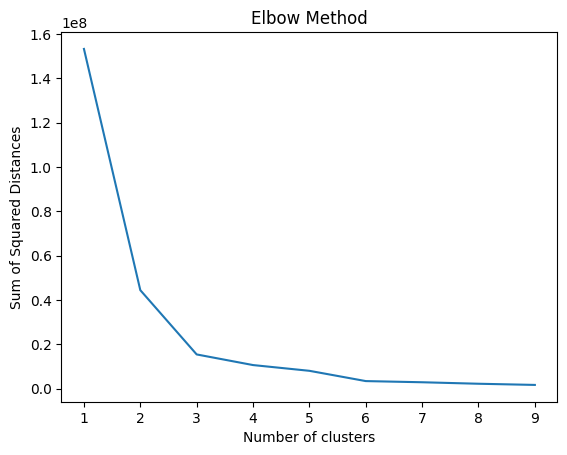

In [38]:
#we will select, from the all_drivers dataset, the variables 'Podium Percentage', 'Points', and 'Highest Grid Position'
selected_data = all_drivers[['Podium Percentage', 'Points', 'Highest Grid Position']]

#making a variable that will hold the Sum of Squared Distances 
SSD = []
#Finding the best number of cluseters from 1 to 10
for i in range(1, 10):
    #making the number of clusters in a variable called 'kmeans'
    kmeans = KMeans(n_clusters = i, max_iter = 250, random_state = 0)
    #fitting the selected data from all_drivers to our kmeans model made above.
    kmeans.fit(selected_data)
    #adding the square distance to SSD
    SSD.append(kmeans.inertia_)

#Plotting the graph for the elbow method to find the best number of clusters 
plt.plot(range(1, 10), SSD)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of Squared Distances')
plt.show()

Based on the Elbow graph above, we see that a number of clusters equal to 3 seems to be ideal for us. This should make sure that we do not over fit our model.

Let's see how k-means with a k = 3 will cluster our data:

In [ ]:
#making a kmeans model with the best number of clusters, which is 3
best_kmeans = KMeans(n_clusters = 3, max_iter = 250, random_state = 0)
#Predicting the class of our data with the best number of clusters 
class_ = best_kmeans.fit_predict(selected_data)

#Adding a new column to all_drivers and setting our predicted classes
all_drivers['Cluster'] = class_
all_drivers.head()



,Number,Team,Country,Podiums,Points,Grands Prix Entered,World Championships,Highest Grid Position,Year,Podium Percentage,Has WC,Cluster
0,44.0,Mercedes,United Kingdom,151,3431.0,250,6,1,2019,0.604000,1,2
1,77.0,Mercedes,Finland,45,1289.0,140,0,1,2019,0.321429,0,0
2,33.0,Red Bull Racing,Netherlands,31,948.0,102,0,1,2019,0.303922,0,0
3,16.0,Ferrari,Monaco,10,303.0,42,0,1,2019,0.238095,0,1
4,5.0,Ferrari,Germany,120,2985.0,241,4,1,2019,0.497925,1,2


Lets see how much our variables influence the class prediction of our k-means model:

In [ ]:
#Creating some sub-dataframes for 'Podium Percentage', 'Points', 'Highest Grid Position'
podium_to_class = all_drivers[['Podium Percentage', 'Cluster']]
prev_points_to_class = all_drivers[['Points', 'Cluster']]
grid_pos__to_class = all_drivers[['Highest Grid Position', 'Cluster']]

print(f"The correlation between Podium Percentage: {podium_to_class.corr().iloc[1,0]}")
print(f"The correlation between Previous Points Percentage: {prev_points_to_class.corr().iloc[1,0]}")
print(f"The correlation between Highest Grid Position Percentage: {grid_pos__to_class.corr().iloc[1,0]}")


The correlation between Podium Percentage: 0.03535578966409758
The correlation between Previous Points Percentage: 0.10583439063861579
The correlation between Highest Grid Position Percentage: 0.18425136924366953


As we see, out of the variables we used to classify our points, it seems that the variable 'Highest Grid Position' has about an 18.42% correlation with the classes asigned. It is followed by their total career points until that season (~10.58%), and lastly, their podium percentage (~3.54%).

Based on this, we can say that the variables we chose have a positive correlation, however a mild one, with the strongest correlation being a somewhate positive correlation, and with the smallest correlation being a pretty weak positive correlation.